# Color Palette Generator

This project converts gives you a nice set of colour palette from the image you feed. 

### Introduction
This is a images based project. The aim of this project is to generate a nice set of color palettes from the image provided. Let's look at the steps taken to get this into action.
<br>
1. Get the image and try to sample it choosing less no of pixels gives us advantage of being faster also there is a high chance that sampling removes the outliers or pixels that are rare.
2. Once we have sampled the image we try to seperate the background and foreground background serve as a seperate palette and on foreground we use k nearest neighbors to get x no of distinct colors.


This pretty much sums up the algorithm that we are using.


### Importing the libraries

In [0]:
import numpy as np
from PIL import Image
from scipy.cluster.vq import kmeans, vq
from matplotlib import pyplot as plt

### Defining the constants

In [0]:
car = "car.jpeg"
note = "notesA2.jpg"

### Loading the images and exploring them

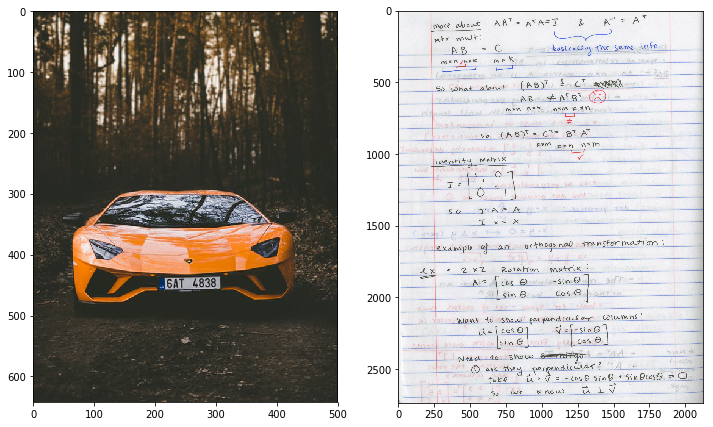

In [0]:
carimage = Image.open(car)
noteimage = Image.open(note)

fig = plt.figure( figsize=(12,10) )
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(carimage)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(noteimage)

In [0]:
noteimg = np.asarray(carimage)
print ("Note Image shape " , noteimg.shape )

Note Image shape  (643, 500, 3)


In [0]:
resizedImage = noteimg.reshape((-1,3))
resizedImage.shape

(321500, 3)

## Sample the image
Sampling is a process of getting a subset from the data. Here also we will get a subset of the pixels present in the image. the no of samples is a hyperparameter and can be changed by changing the fraction option. Once we select X pixels we shuffle them to get random indexes and return the sample.

In [0]:
def sample_image( img , options ):
  
  #convert image into 
  pixImage = img.reshape((-1,3 ))
  totalpixels = pixImage.shape[0]
  
  #calculate how many samples are needed
  num_samples = int( totalpixels * options["fraction"] )
  
  #create an np array of indexes and shuffle them
  idx = np.arange( num_samples)
  np.random.shuffle(idx)
  
  #return random sample pixels
  return  pixImage[idx]


### Quantize
**Quantization** , It is the concept that a physical quantity can have only certain discrete values.

In order to get the background we are relying on the fact that the background pixels will have maximum area in an image. which means that same value of pixels but since background can be a little dynamic we can get different shades. to overcome this we try to create bins where we group the same colors by omitting certain bits. So suppose we have "R" value of a pixel as 243 no the binary representation of this is 11110011 now if we omit 3 bits we can have 11110000 which is 240 this way pixel with 240 or 241 will also have the same value. thus in the end we will have nearby values binned together.

In [0]:
def quantize(image, bits_per_channel=None):

    '''Reduces the number of bits per channel in the given image.'''

    if bits_per_channel is None:
        bits_per_channel = 6

    assert image.dtype == np.uint8

    shift = 8-bits_per_channel
    halfbin = (1 << shift   ) >> 1

    return ((image.astype(int) >> shift) << shift) + halfbin





### Packing and Unpacking the RGB Values
This function just encodes the RGB Value from (243,242,123) to (243242123). After this we can calculate which value has the most count i.e occuring the most and thus be taken as background.

Once we have calculate the bakground we will unpack the rgb values that we had packed earlier.

In [0]:
def pack_rgb(rgb):

    '''Packs a 24-bit RGB triples into a single integer,
works on both arrays and tuples.'''

    orig_shape = None

    if isinstance(rgb, np.ndarray):
        assert rgb.shape[-1] == 3
        orig_shape = rgb.shape[:-1]
    else:
        assert len(rgb) == 3
        rgb = np.array(rgb)

    rgb = rgb.astype(int).reshape((-1, 3))

    packed = (rgb[:, 0] << 16 |
              rgb[:, 1] << 8 |
              rgb[:, 2])
 

    if orig_shape is None:
        return packed
    else:
        return packed.reshape(orig_shape)

In [0]:
def unpack_rgb(packed):

    '''Unpacks a single integer or array of integers into one or more
24-bit RGB values.

    '''

    orig_shape = None

    if isinstance(packed, np.ndarray):
        assert packed.dtype == int
        orig_shape = packed.shape
        packed = packed.reshape((-1, 1))

    rgb = ((packed >> 16) & 0xff,
           (packed >> 8) & 0xff,
           (packed) & 0xff)

    if orig_shape is None:
        return rgb
    else:
        return np.hstack(rgb).reshape(orig_shape + (3,))

### Background Color Calculation
To calculate background we need to find the most occuring color.


In [0]:
def get_bg_color(image, bits_per_channel=None):

    '''Obtains the background color from an image or array of RGB colors
by grouping similar colors into bins and finding the most frequent
one.

    '''

    assert image.shape[-1] == 3

    quantized = quantize(image, bits_per_channel).astype(int)
    packed = pack_rgb(quantized)

    unique, counts = np.unique(packed, return_counts=True)

    packed_mode = unique[counts.argmax()]

    return unpack_rgb(packed_mode)

In [0]:
def rgb_to_sv(rgb):

    '''Convert an RGB image or array of RGB colors to saturation and
value, returning each one as a separate 32-bit floating point array or
value.

    '''

    if not isinstance(rgb, np.ndarray):
        rgb = np.array(rgb)

    axis = len(rgb.shape)-1
    cmax = rgb.max(axis=axis).astype(np.float32)
    cmin = rgb.min(axis=axis).astype(np.float32)
    delta = cmax - cmin

    saturation = delta.astype(np.float32) / cmax.astype(np.float32)
    saturation = np.where(cmax == 0, 0, saturation)

    value = cmax/255.0

    return saturation, value


In [0]:
def get_fg_mask(bg_color, samples, options) :
  
  '''
  determines if the pixel is in background or foreground
  a pixel is in foreground if its value is in background 
  '''
  
  b_sat , b_val = rgb_to_sv( bg_color )
  f_sat , f_val = rgb_to_sv( samples )
  
  s_diff, v_diff = np.abs(b_sat - f_sat) , np.abs(b_val - f_val)
  print(s_diff ,  v_diff )
  return ( ( s_diff >= options['sat_threshold'] ) | ( v_diff >= options['val_threshold'] ) ) 

In [0]:
def get_palette(samples, options, return_mask=False, kmeans_iter=40):

    '''
    Extract the palette for the set of sampled RGB values. The first
    palette entry is always the background color; the rest are determined
    from foreground pixels by running K-means clustering. Returns the
    palette, as well as a mask corresponding to the foreground pixels.

    '''



    bg_color = get_bg_color(samples, 6)

    fg_mask = get_fg_mask(bg_color, samples, options)
    
    print ( options['num_colors'] , samples[fg_mask])
    centers, _ = kmeans(samples[fg_mask].astype(np.float32),
                        options['num_colors']-1,
                        iter=kmeans_iter)

    palette = np.vstack((bg_color, centers)).astype(np.uint8)

    if not return_mask:
        return palette
    else:
        return palette, fg_mask


In [0]:
(1234,) + (3,)

(1234, 3)

In [0]:
options = {
    "fraction" : 0.70,
    "num_colors" : 2,
    "sat_threshold" : 0.20 ,
    "val_threshold" : 0.25,
    "quiet" : True
}

In [0]:
samples = sample_image(noteimg, options)
pallette = get_palette(samples , options )

[0.1221532  0.08253969 0.23809525 ... 0.37844613 0.0675526  0.42650104] [0.01568627 0.01176471 0.23529412 ... 0.20784314 0.00392157 0.01568627]
2 [[102  90  68]
 [ 60  55  35]
 [ 54  47  37]
 ...
 [243 166 136]
 [ 95  75  50]
 [ 46  37  22]]


In [0]:
pallette[1] = [223,221,13]

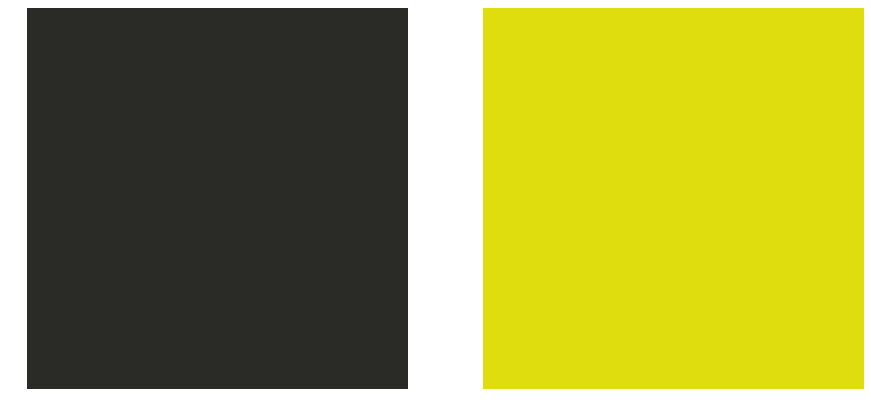

In [0]:
fig = plt.figure(figsize=(15,8))
for idx , val in enumerate(pallette):
  color1 = np.full( ( 100 , 100 , 3 ) , val )
  ax = fig.add_subplot( 1, len(pallette), idx+1 )
  ax.axis('off')
  ax.imshow(color1)
  


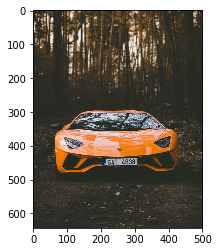

In [0]:
plt.imshow(carimage)

In [0]:
def apply_palette(img, palette, options):

    '''Apply the pallete to the given image. The first step is to set all
background pixels to the background color; then, nearest-neighbor
matching is used to map each foreground color to the closest one in
the palette.

    '''



    bg_color = palette[0]

    fg_mask = get_fg_mask(bg_color, img, options)

    orig_shape = img.shape

    pixels = img.reshape((-1, 3))
    fg_mask = fg_mask.flatten()

    num_pixels = pixels.shape[0]

    labels = np.zeros(num_pixels, dtype=np.uint8)

    labels[fg_mask], _ = vq(pixels[fg_mask], palette)

    return labels.reshape(orig_shape[:-1])

In [0]:
labels = apply_palette(noteimg, pallette, options)
# output_img = Image.fromarray(labels, 'JPEG')
output_img = Image.fromarray(labels , 'P')
output_img.putpalette(pallette.flatten())
# output_img.save('file.jpeg')

[[0.0675526  0.04761905 0.07549361 ... 0.21726191 0.21088436 0.1739927 ]
 [0.04429679 0.07142857 0.07549361 ... 0.17142859 0.17142859 0.16008106]
 [0.0675526  0.0675526  0.07142857 ... 0.17748919 0.13732004 0.13203463]
 ...
 [0.04429679 0.04429679 0.04429679 ... 0.07142857 0.07142857 0.07142857]
 [0.04429679 0.04429679 0.04429679 ... 0.07142857 0.07142857 0.07142857]
 [0.04429679 0.04429679 0.04429679 ... 0.07142857 0.07142857 0.07142857]] [[0.00392157 0.         0.00392157 ... 0.02352941 0.02745098 0.03921568]
 [0.00392157 0.         0.00392157 ... 0.01176471 0.01176471 0.01960784]
 [0.00392157 0.00392157 0.         ... 0.00784314 0.00392157 0.00784314]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]]


In [0]:
output_img.save('re.png')

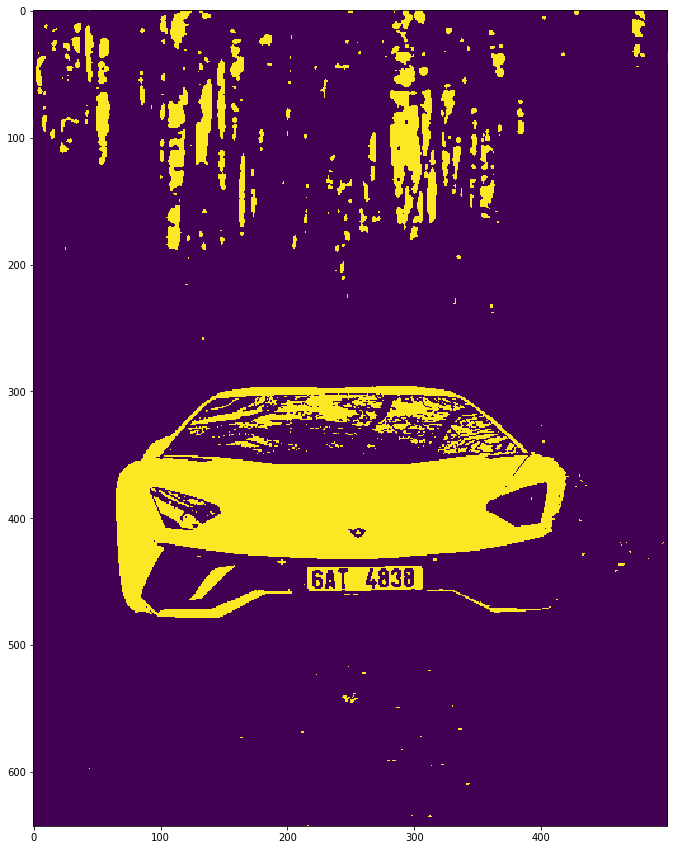

In [0]:
plt.figure( figsize =(45,15) )
plt.imshow( Image.open('re.png') )

In [0]:
REplace the color pallete